# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [28]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

In [29]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [30]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [31]:
# Index data by Date
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
display_df(data.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN


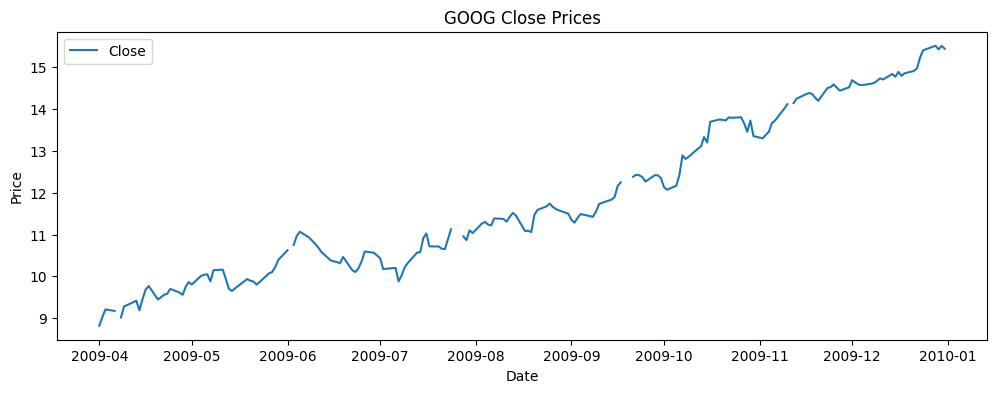

In [32]:
# Plot the Close Data
plt.figure(figsize=(12,4))
plt.plot(data['Close'], label='Close')
plt.title('GOOG Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [33]:
# Check for null values
data.isnull().sum()

Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [34]:
# forward fill missing values
data.fillna(method='ffill', inplace=True)

C:\Users\Ohara\AppData\Local\Temp\ipykernel_35336\754871169.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [35]:
# Check for null values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

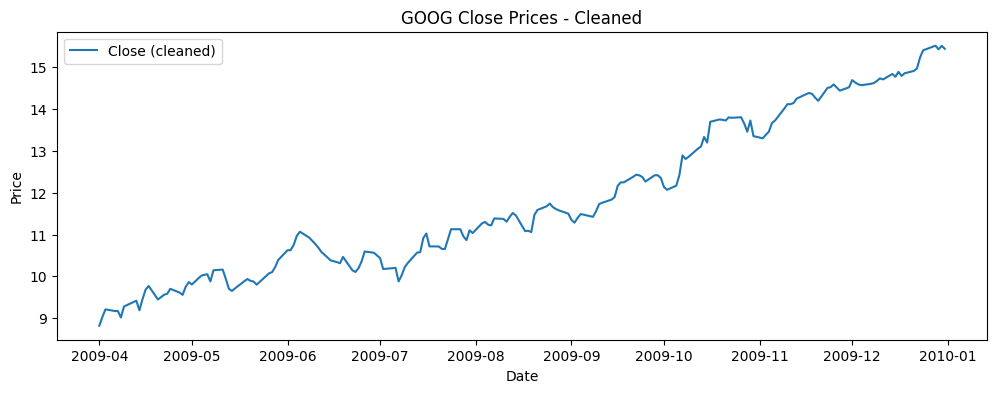

In [36]:
# Plot the cleaned Close Data
plt.figure(figsize=(12,4))
plt.plot(data['Close'], label='Close (cleaned)')
plt.title('GOOG Close Prices - Cleaned')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [37]:
# Calculate 20-day bollinger bands

rolling_mean = data['Close'].rolling(window=20).mean()
rolling_std = data['Close'].rolling(window=20).std()

data['bb_upper'] = rolling_mean + (rolling_std * 2)
data['bb_lower'] = rolling_mean - (rolling_std * 2)

In [38]:
# Remove rows with NaN bollinger bands
data.dropna(subset=['bb_upper', 'bb_lower'], inplace=True)

In [39]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'bb_upper', 'bb_lower']].copy()

# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

,Close,bb_upper,bb_lower
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898


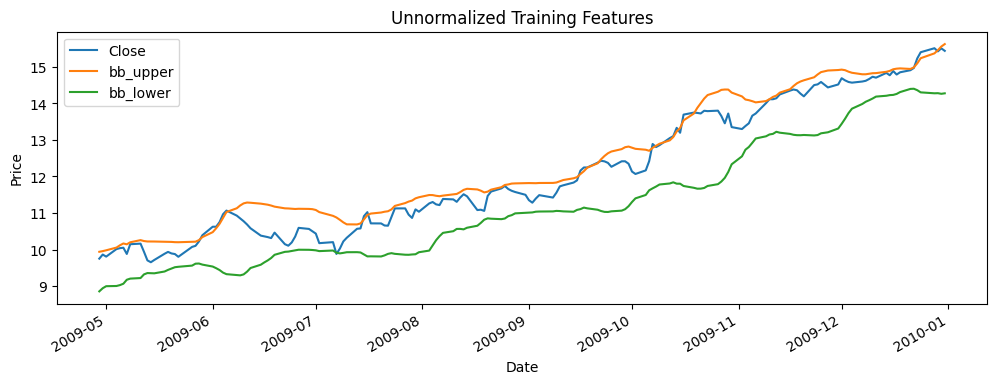

In [40]:
# Display & Plot Un-normalized Dataset
display_df(dataset.head())
dataset.plot(figsize=(12,4), title='Unnormalized Training Features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [41]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[col].values.reshape(-1, 1)
    normalizer.fit(column_data)
    normed_dataset[col] = normalizer.transform(column_data)
    normlist.append(normalizer)

,Close,bb_upper,bb_lower
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692


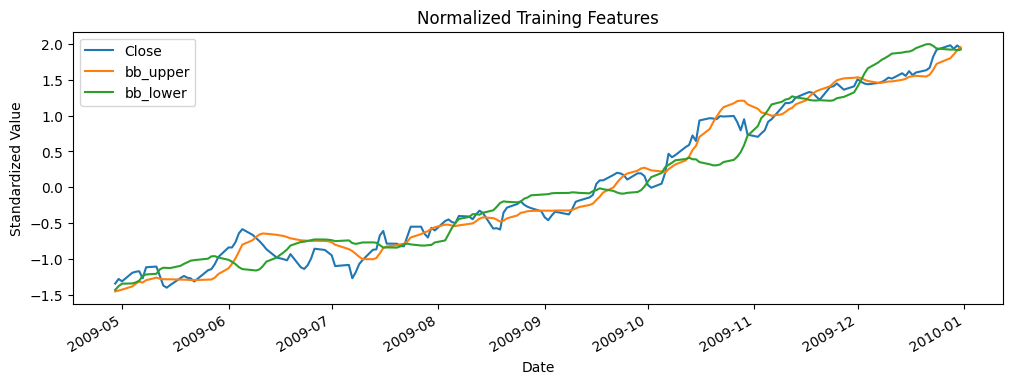

In [42]:
# Display & Plot Normalized Dataset
display_df(normed_dataset.head())
normed_dataset.plot(figsize=(12,4), title='Normalized Training Features')
plt.xlabel('Date')
plt.ylabel('Standardized Value')
plt.show()

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [43]:
# split dataset df into train (50%) and test (50%) datasets

split_idx = len(normed_dataset) // 2

train_df = normed_dataset.iloc[:split_idx].copy()
test_df = normed_dataset.iloc[split_idx:].copy()

In [44]:
# display train and test dfs (ensure no overlap)
print(f'Train rows: {len(train_df)}, Test rows: {len(test_df)}')
print(f'Train end date: {train_df.index[-1]} | Test start date: {test_df.index[0]}')
display_df(train_df.head())
display_df(test_df.head())

Train rows: 86, Test rows: 86
Train end date: 2009-08-28 00:00:00 | Test start date: 2009-08-31 00:00:00


,Close,bb_upper,bb_lower
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692


,Close,bb_upper,bb_lower
Date,,,
2009-08-31,-0.333839,-0.324508,-0.101821
2009-09-01,-0.418697,-0.324366,-0.098844
2009-09-02,-0.458183,-0.325247,-0.095058
2009-09-03,-0.393426,-0.326468,-0.082783
2009-09-04,-0.339151,-0.323058,-0.079844


In [45]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)
# print the shape of X_train to remind yourself how many examples and features are in the dataset
print(f'X_train shape: {X_train.shape}')
# track index to remember which feature is which
idx_close = list(train_df.columns).index('Close')
idx_bb_upper = list(train_df.columns).index('bb_upper')
idx_bb_lower = list(train_df.columns).index('bb_lower')

X_train shape: (86, 3)


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [46]:
@keras.saving.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super().__init__()

        model = keras.Sequential(
            [
                keras.layers.Input(shape=(state_size,)),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(32, activation='relu'),
                keras.layers.Dense(8, activation='relu'),
                keras.layers.Dense(action_size, activation='linear'),
            ]
        )

        model.compile(
            loss='mse',
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
        )

        # save model to DQN instance
        self.model = model

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [47]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size # How many days of historical data do we want to include in our state representation?
        self.num_features = num_features # How many training features do we have?
        self.state_size = window_size*num_features # State size includes number of training features per day, and number of lookback days 
        self.action_size = 3 # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000) # Bound memory size: once the memory reaches 1000 units, the lefthand values are discarded as righthand values are added
        self.inventory = [] # Inventory to hold trades
        self.model_name = model_name # filename for saved model checkpoint loading
        self.test_mode = test_mode # flag for testing (allows model load from checkpoint model_name)

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.997

        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    #Deep Q Learning (DQL) model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model

    # DQL Predict (with input reshaping)
    #   Input = State
    #   Output = Q-Table of action Q-Values
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))


    # DQL Fit (with input reshaping)
    #   Input = State, Target Q-Table 
    #   Output = MSE Loss between Target Q-Table and Actual Q-Table for State
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)    

    # Agent Action Selector
    #   Input = State
    #   Policy = epsilon-greedy (to minimize possibility of overfitting)
    #   Intitially high epsilon = more random, epsilon decay = less random later
    #   Output = Action (0, 1, or 2)
    def act(self, state): 
        # Choose any action at random (Probablility = epsilon for training mode, 0% for testing mode)
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        # Choose the action which has the highest Q-value (Probablitly = 1-epsilon for training mode, 100% for testing mode)
        act_values = self.get_q_values_for_state(state)
        # return the action that has the highest value from the q-value function.
        return np.argmax(act_values[0])

    # Experience Replay (Learning Function)
    #   Input = Batch of (state, action, next_state) tuples
    #   Optimal Q Selection Policy = Bellman equation
    #   Important Notes = Model fitting step is in this function (fit_model)
    #                     Epsilon decay step is in this function
    #   Output = Model loss from fitting step
    def exp_replay(self, batch_size, losses):
        losses = []
        # define a mini-batch which holds batch_size most recent previous memory steps (i.e. states)
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in mini_batch:
            # reminders: 
            #   - state is a vector containing close & MA values for the current time step
            #   - action is an integer representing the action taken by the act function at the current time step- buy, hold, or sell
            #   - reward represents the profit of a given action - it is either 0 (for buy, hold, and sells which loose money) or the profit in dollars (for a profitable sell)
            #   - next_state is a vector containing close & MA values for the next time step
            #   - done is a boolean flag representing whether or not we are in the last iteration of a training episode (i.e. True when next_state does not exist.)
            if done:
                # special condition for last training epoch in batch (no next_state)
                optimal_q_for_action = reward  
            else:
                # target Q-value is updated using the Bellman equation: reward + gamma * max(predicted Q-value of next state)
                optimal_q_for_action = reward + self.gamma * np.amax(self.get_q_values_for_state(next_state))
            # Get the predicted Q-values of the current state
            target_q_table = self.get_q_values_for_state(state)
            # Update the output Q table - replace the predicted Q value for action with the target Q value for action 
            target_q_table[0][action] = optimal_q_for_action
            # Fit the model where state is X and target_q_table is Y
            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']

        # define epsilon decay (for the act function)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return losses

# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [48]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# returns an an n-day state representation ending at time t
def get_state(data, t, n): 
    # data is the dataset of interest which holds the state values (i.e. Close , BB Upper, BB Lower)
    # t is the current time step 
    # n is the size of the training window 

    # the first step is to get the window of the dataset at the current time step (eg. if window size is 1, we grab the previous and the current time step)
    # remember to define the special case for the first iteration, where there is no previous time step. See lesson X for a reminder of how to do this.
    d = t - n + 1
    block = data[d:t+1] if d >= 0 else np.vstack((np.zeros((-d, data.shape[1])), data[0:t+1]))

    # once we have our state data, we need to apply the sigmoid to each feature.
    res = []
    for i in range(n - 1):
        delta = block[i + 1] - block[i]
        res.append(np.vectorize(sigmoid)(delta))
    # return an array holding the n-day sigmoid state representation
    return np.array([np.concatenate(res)])

### Training Loop

In [49]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set
print(f'Training data shape: {X_train.shape}')

Training data shape: (86, 3)


In [50]:
keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

window_size = 1

agent = Agent(window_size, num_features=X_train.shape[1])

Running episode 0/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.01
Sell: $10.05 | Profit: $0.04
Buy: $10.16
Sell: $9.94 | Profit: -$0.22
Buy: $9.71
Buy: $9.93
Buy: $9.89
Buy: $9.88
Sell: $10.07 | Profit: $0.36
Buy: $10.10
Buy: $10.22
Sell: $10.39 | Profit: $0.46
Buy: $10.62
Sell: $10.62 | Profit: $0.73
Sell: $10.75 | Profit: $0.88
Buy: $10.97
Buy: $10.93
Sell: $10.85 | Profit: $0.75
Sell: $10.58 | Profit: $0.36
Sell: $10.38 | Profit: -$0.24
Sell: $10.36 | Profit: -$0.60
Buy: $10.34
Buy: $10.31
Sell: $10.46 | Profit: -$0.47
Buy: $10.50
Sell: $10.44 | Profit: $0.10
Sell: $10.17 | Profit: -$0.14
Sell: $10.20 | Profit: -$0.30
Buy: $10.02
Sell: $10.22 | Profit: $0.20
Buy: $11.13
Sell: $11.13 | Profit: $0.00
Buy: $10.96
Buy: $10.87
Buy: $11.03
Buy: $11.26
Buy: $11.30
Sell: $11.24 | Profit: $0.28
Buy: $11.22
Sell: $11.38 | Profit: $0.52
Buy: $11.31
Buy: $11.51
Buy: $11.46
Sell: $11.08 | Profit: $0.05
Sell: $11.47 | Profit: $0.20
Sell: $11.59 | Profit: $0.29
Sell: $11.67 | Profit: $0.46
Sell: $11.74 | Profit: $0.43
Buy: $11.61
--------------------

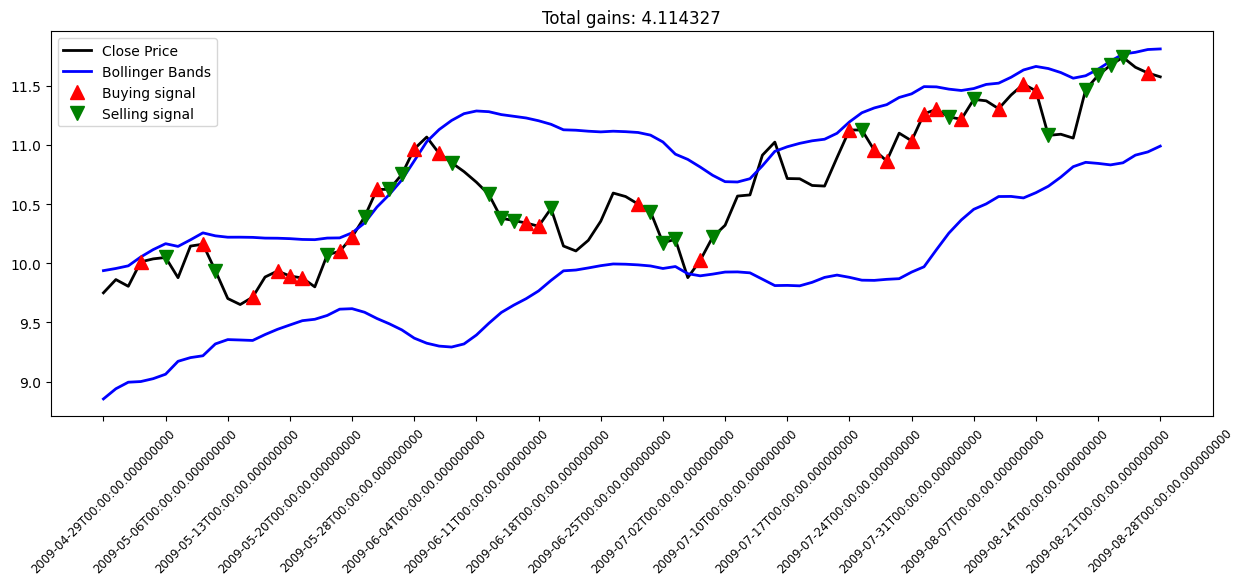

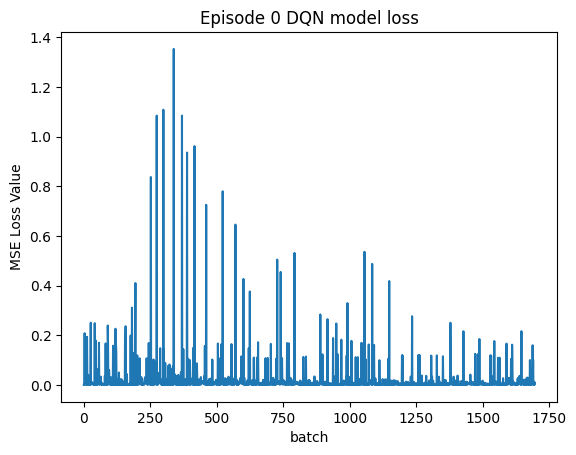

Running episode 1/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.04
Buy: $10.05
Sell: $9.88 | Profit: -$0.16
Buy: $10.15
Sell: $10.16 | Profit: $0.11
Buy: $9.94
Buy: $9.70
Buy: $9.65
Sell: $9.88 | Profit: -$0.26
Sell: $9.93 | Profit: -$0.00
Buy: $9.89
Sell: $9.88 | Profit: $0.17
Sell: $9.80 | Profit: $0.15
Buy: $10.07
Sell: $10.10 | Profit: $0.21
Sell: $10.22 | Profit: $0.15
Buy: $10.97
Sell: $11.07 | Profit: $0.10
Buy: $10.93
Sell: $10.77 | Profit: -$0.15
Buy: $10.34
Buy: $10.46
Sell: $10.15 | Profit: -$0.19
Buy: $10.10
Sell: $10.19 | Profit: -$0.27
Sell: $10.36 | Profit: $0.25
Buy: $10.50
Buy: $10.44
Sell: $10.20 | Profit: -$0.30
Sell: $9.88 | Profit: -$0.56
Buy: $10.32
Sell: $10.57 | Profit: $0.25
Buy: $11.02
Sell: $10.72 | Profit: -$0.31
Buy: $11.13
Sell: $11.13 | Profit: $0.00
Buy: $11.26
Sell: $11.30 | Profit: $0.04
Buy: $11.22
Buy: $11.38
Sell: $11.31 | Profit: $0.09
Buy: $11.42
Sell: $11.51 | Profit: $0.13
Buy: $11.46
Sell: $11.08 | Profit: -$0.34
Sell: $11.09 | Profit: -$0.37
Buy: $11.66
Sell: $11.61 | Profit: -$0.05
--------------

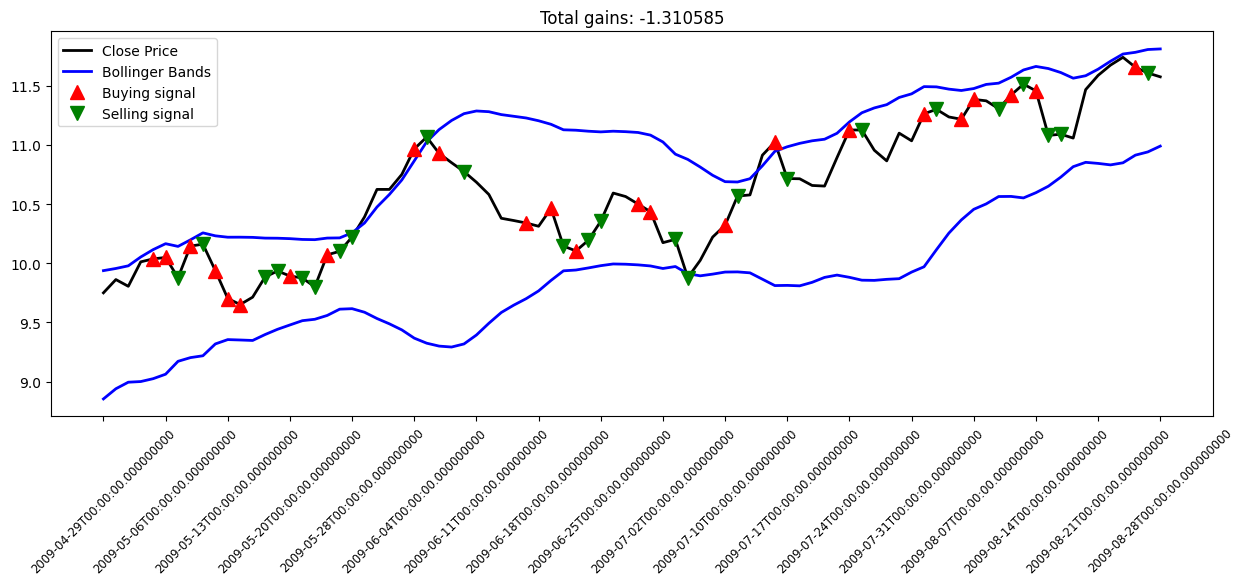

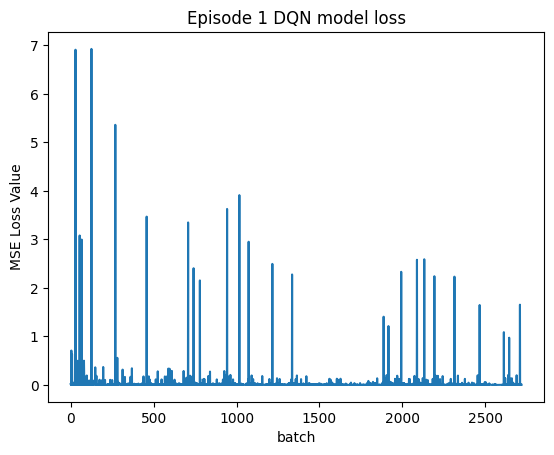

Running episode 2/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.81
Sell: $10.01 | Profit: $0.21
Buy: $9.93
Sell: $9.88 | Profit: -$0.06
Buy: $9.80
Sell: $10.07 | Profit: $0.27
Buy: $11.07
Buy: $10.93
Sell: $10.85 | Profit: -$0.22
Sell: $10.77 | Profit: -$0.15
Buy: $10.68
Sell: $10.58 | Profit: -$0.10
Buy: $10.15
Sell: $10.10 | Profit: -$0.04
Buy: $10.19
Sell: $10.36 | Profit: $0.16
Buy: $10.17
Sell: $10.20 | Profit: $0.03
Buy: $10.02
Sell: $10.22 | Profit: $0.20
Buy: $10.71
Sell: $10.66 | Profit: -$0.06
Buy: $11.37
Sell: $11.31 | Profit: -$0.07
Buy: $11.08
Sell: $11.09 | Profit: $0.01
Buy: $11.47
Sell: $11.59 | Profit: $0.12
Buy: $11.67
Buy: $11.74
Sell: $11.66 | Profit: -$0.02
--------------------------------
Episode 2
Total Profit: $0.28
Total Winners: $0.99
Total Losers: -$0.72
Max Loss: 1.6181367635726929
Total Loss: 34.13266902227867
--------------------------------


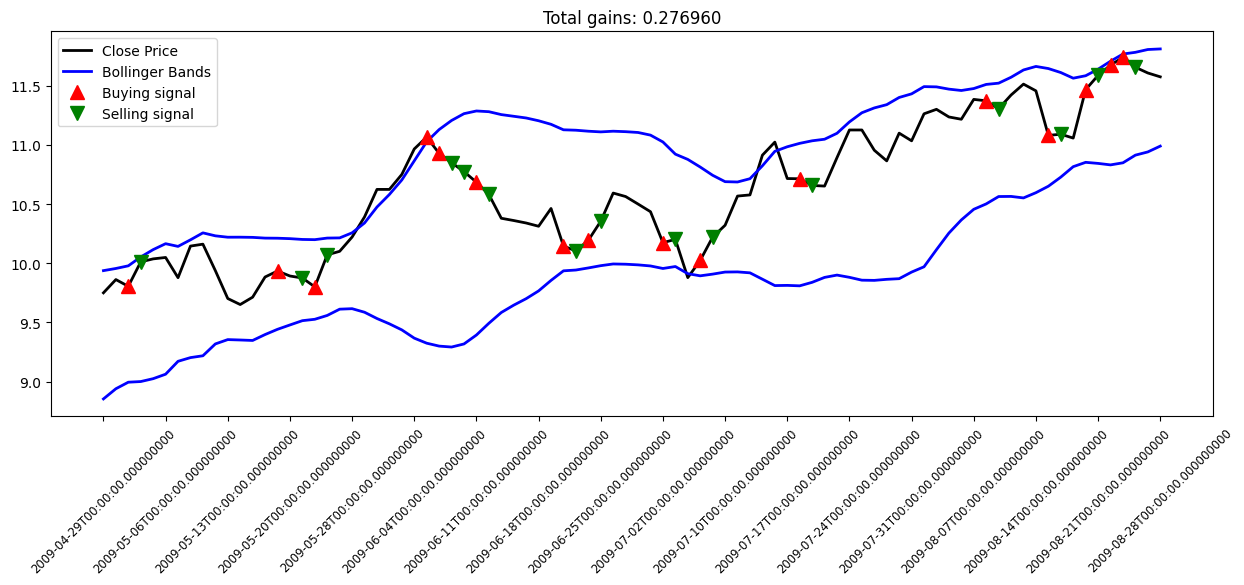

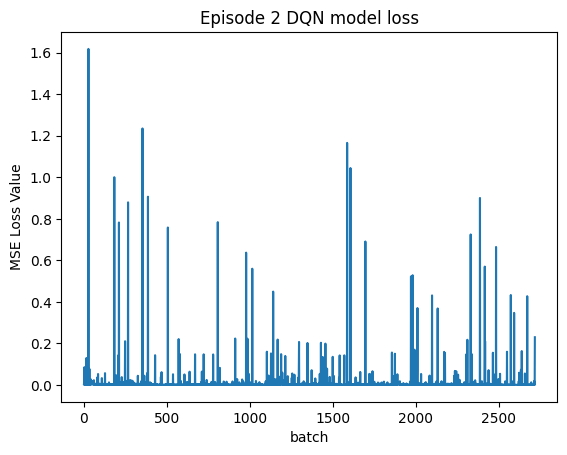

Running episode 3/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.88
Sell: $10.16 | Profit: $0.28
Buy: $9.88
Sell: $9.80 | Profit: -$0.07
Buy: $10.07
Sell: $10.39 | Profit: $0.32
Buy: $10.34
Sell: $10.31 | Profit: -$0.03
Buy: $10.50
Sell: $10.44 | Profit: -$0.06
Buy: $10.20
Sell: $9.88 | Profit: -$0.32
Buy: $10.32
Sell: $10.91 | Profit: $0.59
Buy: $10.89
Sell: $11.13 | Profit: $0.23
Buy: $11.42
Sell: $11.51 | Profit: $0.09
Buy: $11.08
Sell: $11.06 | Profit: -$0.02
Buy: $11.59
Sell: $11.67 | Profit: $0.09
--------------------------------
Episode 3
Total Profit: $1.10
Total Winners: $1.61
Total Losers: -$0.51
Max Loss: 1.0562338829040527
Total Loss: 22.84370667951037
--------------------------------


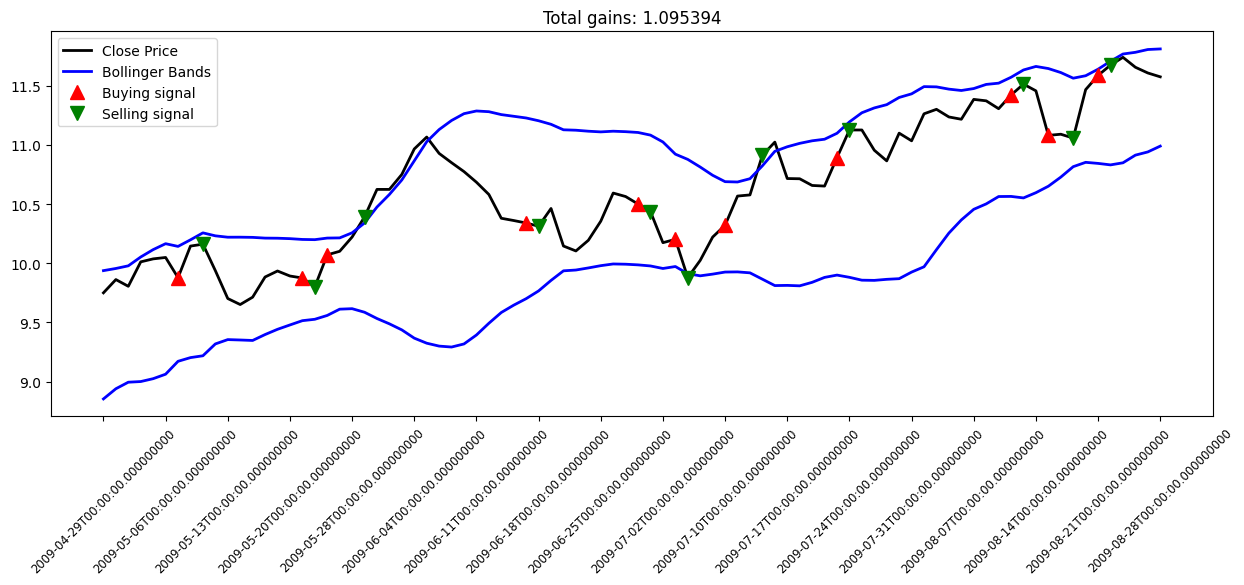

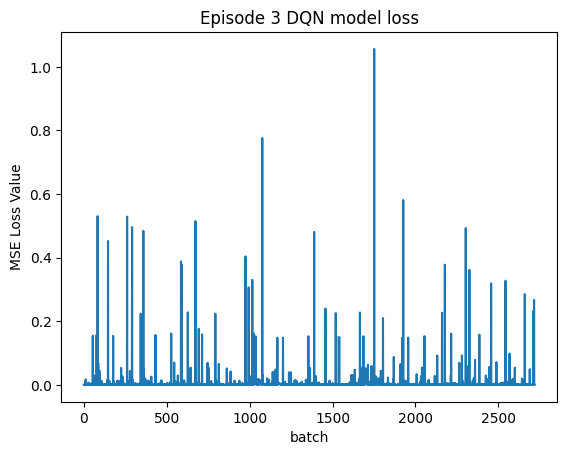

Running episode 4/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.01
Sell: $10.04 | Profit: $0.03
Buy: $9.88
Buy: $10.15
Sell: $10.16 | Profit: $0.28
Sell: $9.94 | Profit: -$0.21
Buy: $9.70
Sell: $9.65 | Profit: -$0.05
Buy: $9.71
Sell: $9.88 | Profit: $0.17
Buy: $10.68
Sell: $10.58 | Profit: -$0.10
Buy: $10.34
Sell: $10.31 | Profit: -$0.03
Buy: $10.56
Sell: $10.50 | Profit: -$0.06
Buy: $10.22
Sell: $10.32 | Profit: $0.10
Buy: $11.02
Sell: $10.72 | Profit: -$0.31
Buy: $11.13
Sell: $11.13 | Profit: $0.00
Buy: $11.47
Buy: $11.59
Buy: $11.67
Sell: $11.74 | Profit: $0.27
Buy: $11.66
Buy: $11.61
--------------------------------
Episode 4
Total Profit: $0.09
Total Winners: $0.85
Total Losers: -$0.76
Max Loss: 0.491817831993103
Total Loss: 16.144893750779946
--------------------------------


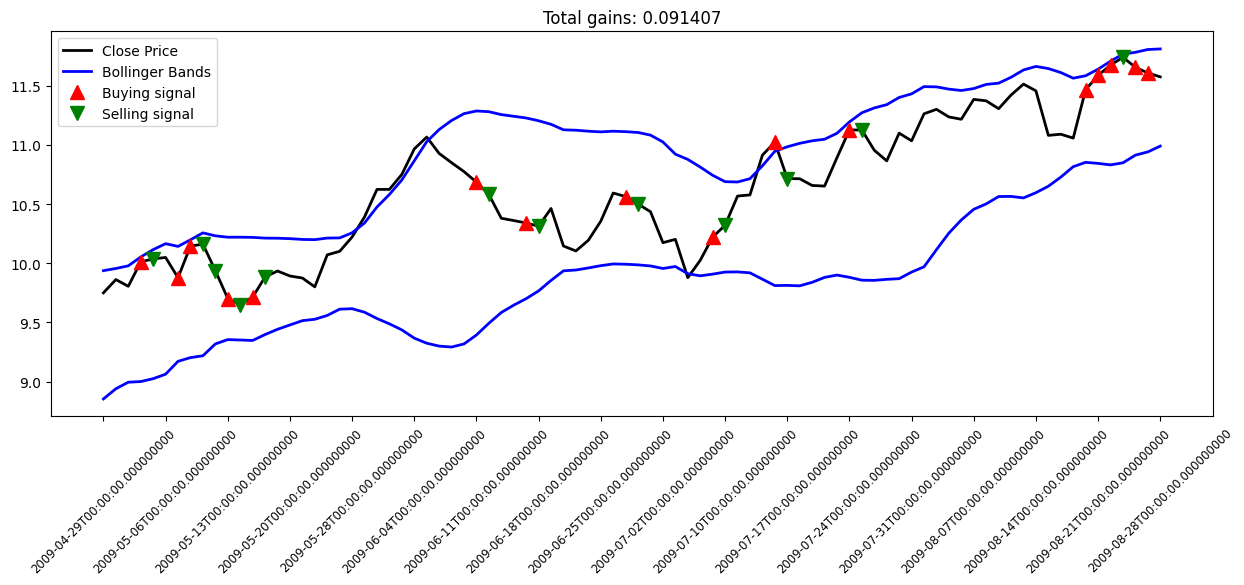

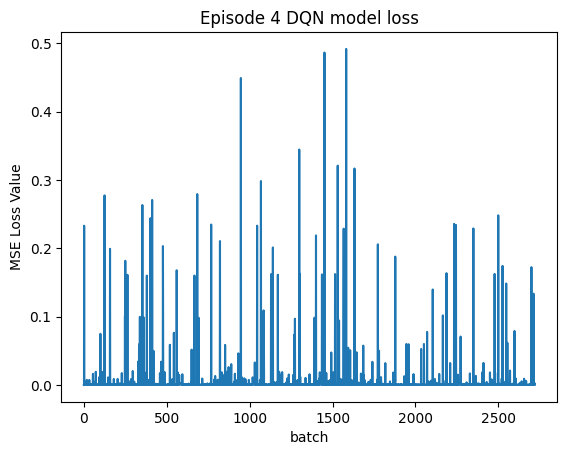

Running episode 5/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.88
Sell: $9.93 | Profit: $0.05
Buy: $9.89
Buy: $9.80
Sell: $10.22 | Profit: $0.33
Sell: $10.62 | Profit: $0.82
Buy: $10.36
Buy: $10.34
Sell: $10.31 | Profit: -$0.05
Sell: $10.46 | Profit: $0.12
Buy: $10.20
Sell: $9.88 | Profit: -$0.32
Buy: $10.89
Sell: $11.13 | Profit: $0.23
Buy: $10.96
Sell: $10.87 | Profit: -$0.09
Buy: $11.30
Sell: $11.24 | Profit: -$0.06
Buy: $11.38
Sell: $11.31 | Profit: -$0.08
Buy: $11.09
Sell: $11.06 | Profit: -$0.03
--------------------------------
Episode 5
Total Profit: $0.92
Total Winners: $1.56
Total Losers: -$0.64
Max Loss: 0.5039675831794739
Total Loss: 13.985184305430824
--------------------------------


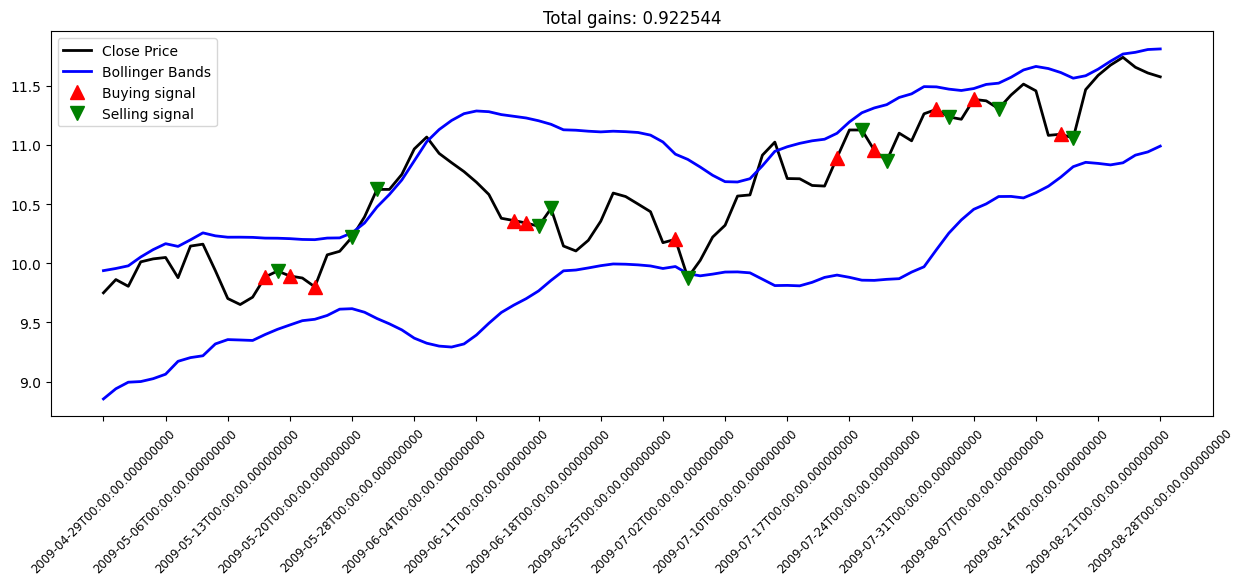

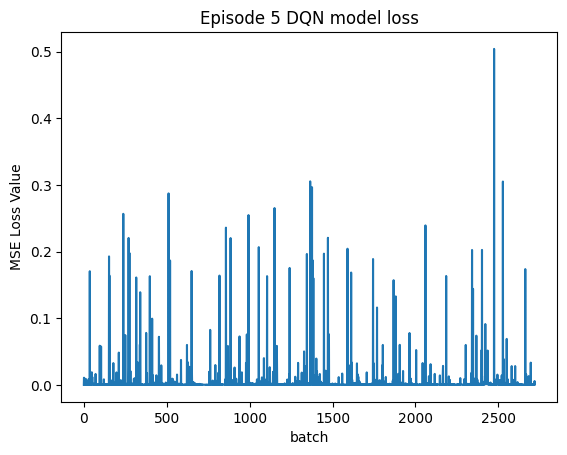

Running episode 6/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.81
Sell: $10.01 | Profit: $0.21
Buy: $10.04
Sell: $10.05 | Profit: $0.01
Buy: $10.16
Sell: $9.70 | Profit: -$0.46
Buy: $10.62
Sell: $10.97 | Profit: $0.34
Buy: $10.68
Sell: $10.58 | Profit: -$0.10
Buy: $10.15
Sell: $10.10 | Profit: -$0.04
Buy: $10.59
Sell: $10.50 | Profit: -$0.09
Buy: $11.10
Sell: $11.03 | Profit: -$0.06
Buy: $11.22
Sell: $11.38 | Profit: $0.17
Buy: $11.42
Sell: $11.46 | Profit: $0.04
Buy: $11.47
Buy: $11.59
Buy: $11.67
Sell: $11.74 | Profit: $0.27
Sell: $11.66 | Profit: $0.07
Sell: $11.61 | Profit: -$0.07
--------------------------------
Episode 6
Total Profit: $0.28
Total Winners: $1.11
Total Losers: -$0.83
Max Loss: 0.4210115969181061
Total Loss: 16.43677713823511
--------------------------------


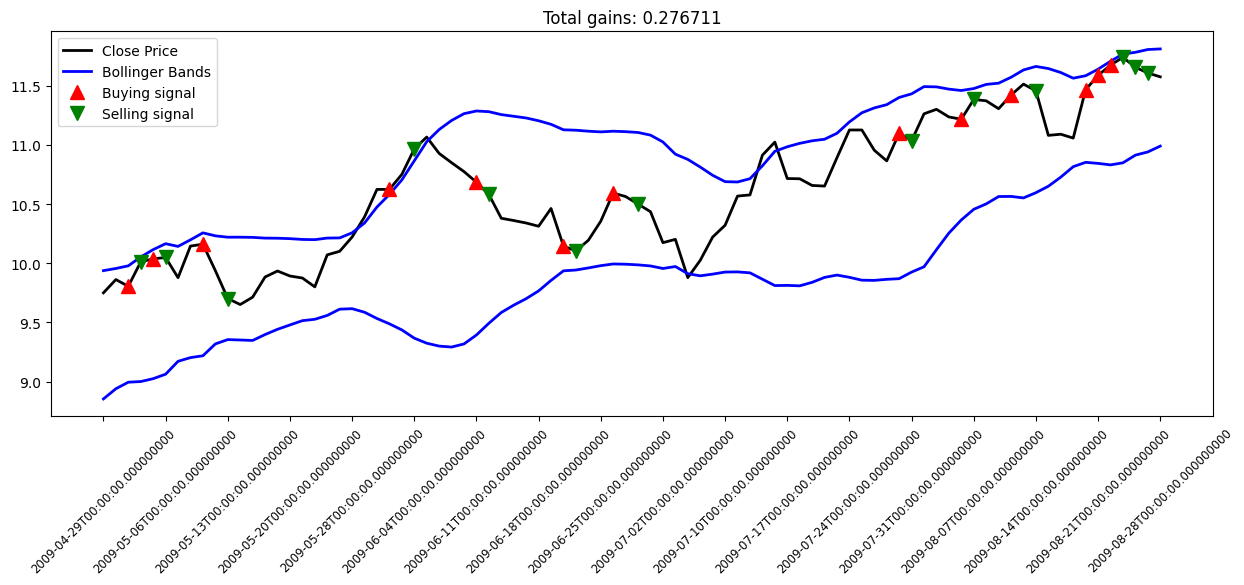

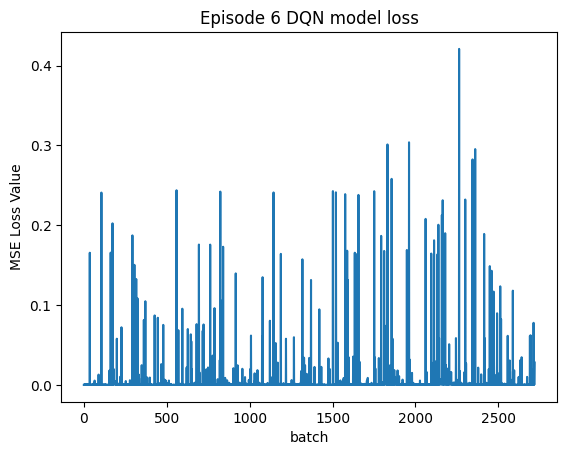

Running episode 7/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.15
Sell: $10.16 | Profit: $0.02
Buy: $9.93
Sell: $9.89 | Profit: -$0.04
Buy: $9.88
Sell: $9.80 | Profit: -$0.07
Buy: $10.68
Sell: $10.58 | Profit: -$0.10
Buy: $10.46
Sell: $10.10 | Profit: -$0.36
Buy: $11.42
Buy: $11.51
Sell: $11.46 | Profit: $0.04
Sell: $11.08 | Profit: -$0.43
--------------------------------
Episode 7
Total Profit: -$0.96
Total Winners: $0.05
Total Losers: -$1.01
Max Loss: 0.24397170543670654
Total Loss: 10.81122449778028
--------------------------------


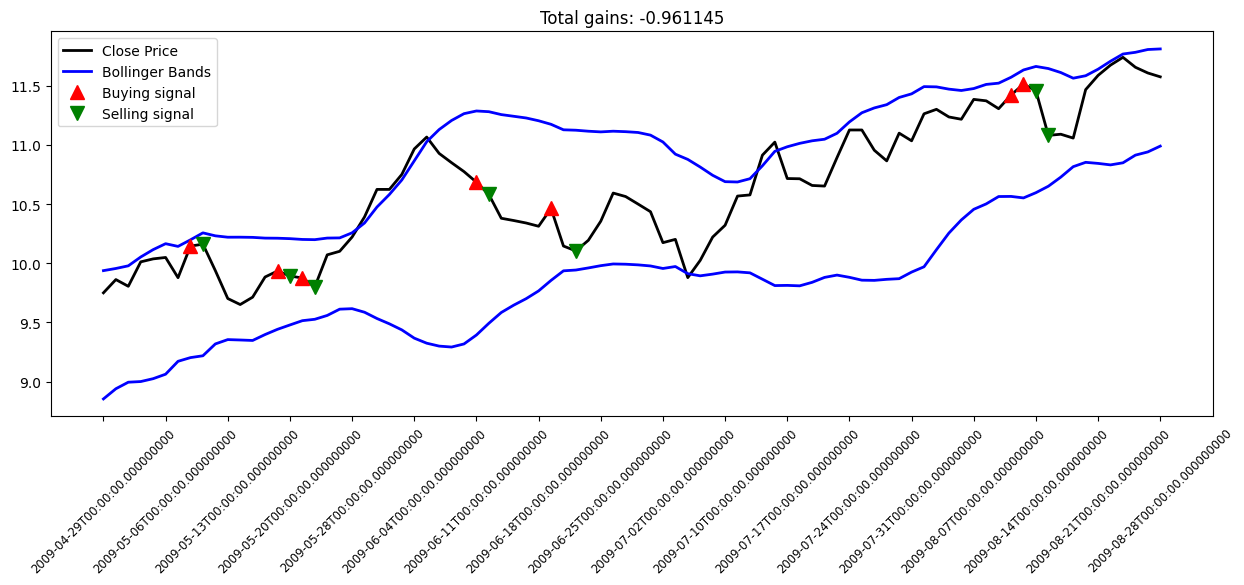

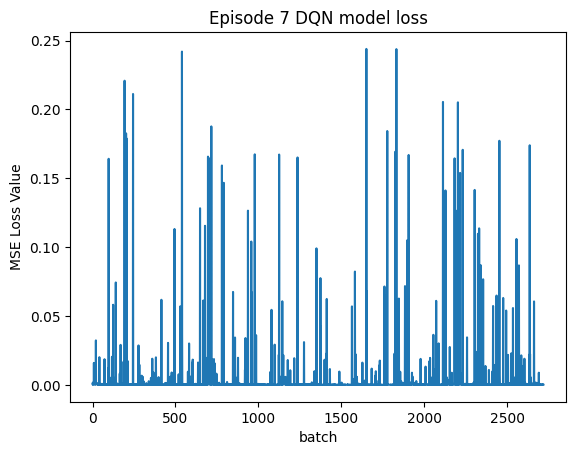

Running episode 8/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.62
Sell: $10.62 | Profit: $0.00
Buy: $10.93
Sell: $10.85 | Profit: -$0.08
Buy: $10.20
Sell: $9.88 | Profit: -$0.32
--------------------------------
Episode 8
Total Profit: -$0.40
Total Winners: $0.00
Total Losers: -$0.40
Max Loss: 0.2744649648666382
Total Loss: 7.828590618410824
--------------------------------


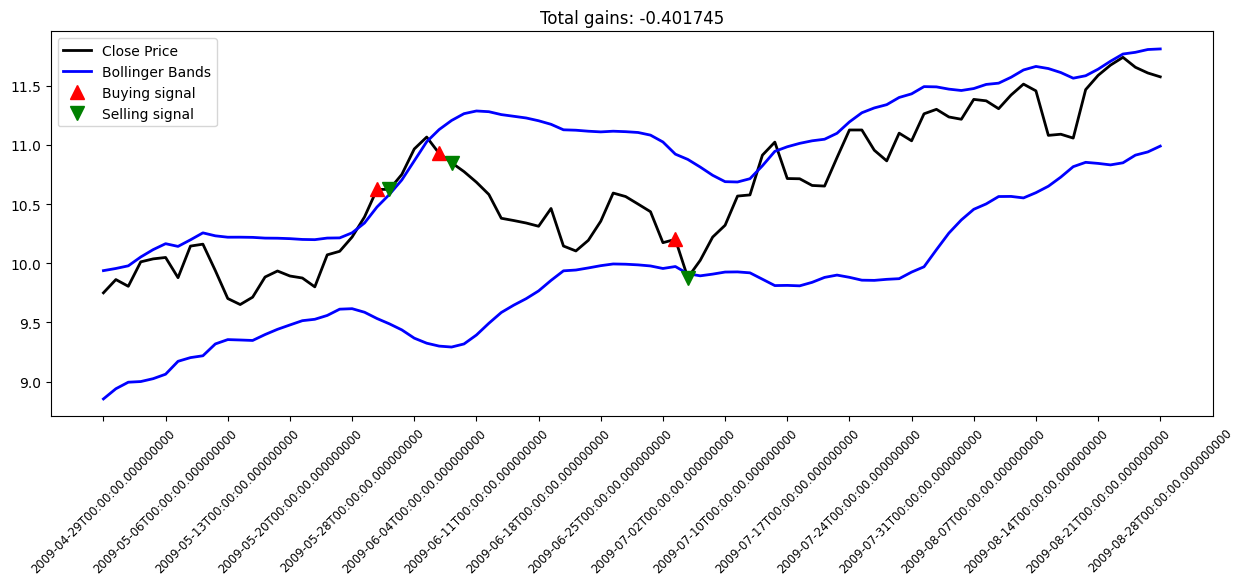

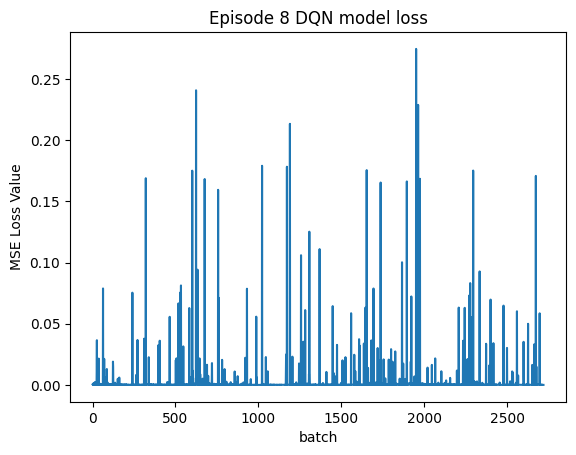

Running episode 9/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.75
Sell: $9.86 | Profit: $0.11
Buy: $10.39
Sell: $10.62 | Profit: $0.23
Buy: $10.75
Sell: $10.97 | Profit: $0.21
Buy: $10.71
Sell: $10.66 | Profit: -$0.06
Buy: $11.13
Sell: $10.96 | Profit: -$0.17
Buy: $11.26
Sell: $11.30 | Profit: $0.04
Buy: $11.51
Sell: $11.47 | Profit: -$0.05
--------------------------------
Episode 9
Total Profit: $0.32
Total Winners: $0.60
Total Losers: -$0.27
Max Loss: 0.28513842821121216
Total Loss: 10.953746262000603
--------------------------------


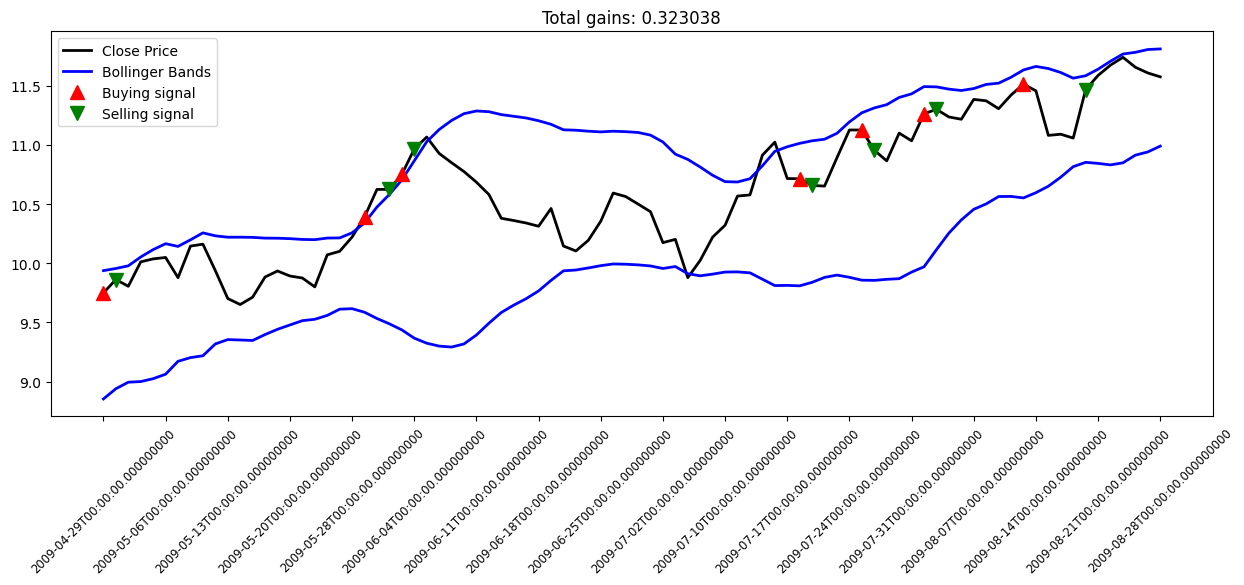

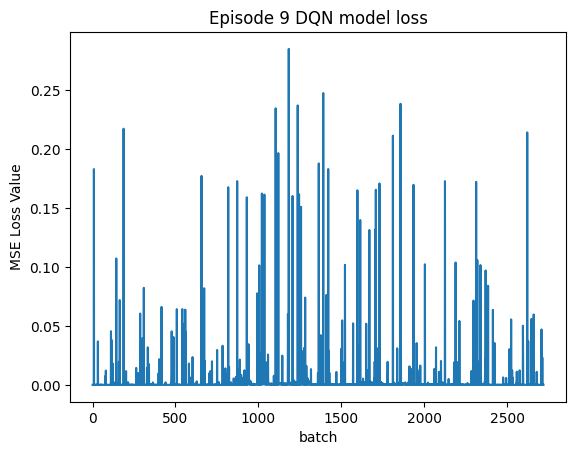

Running episode 10/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.65
Sell: $9.71 | Profit: $0.06
Buy: $10.77
Sell: $10.68 | Profit: -$0.09
Buy: $9.88
Sell: $10.02 | Profit: $0.15
--------------------------------
Episode 10
Total Profit: $0.12
Total Winners: $0.21
Total Losers: -$0.09
Max Loss: 0.2483379989862442
Total Loss: 6.665472968930575
--------------------------------


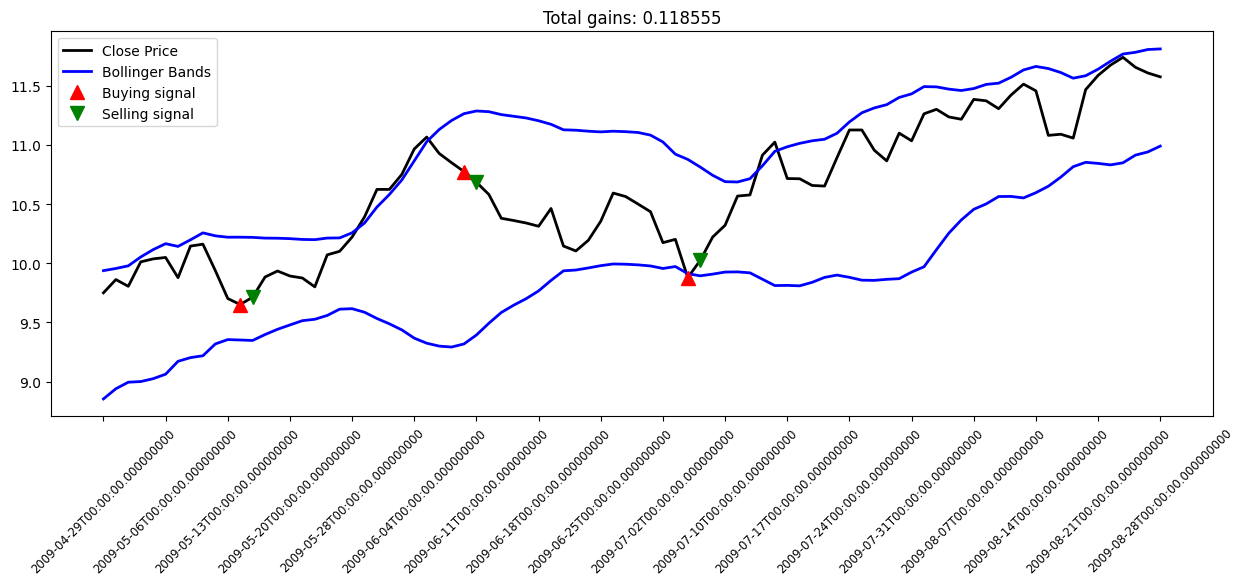

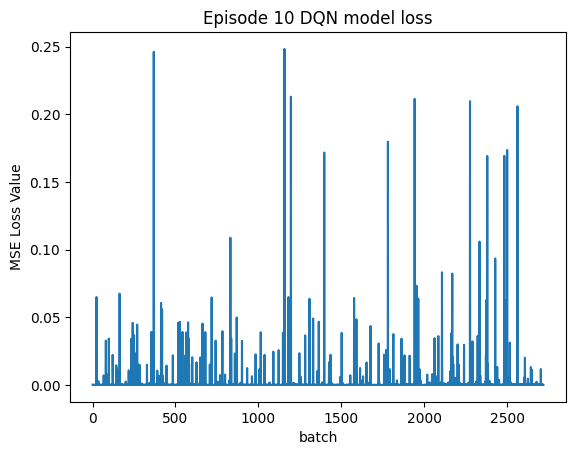

Running episode 11/20:   0%|          | 0/85 [00:00<?, ?it/s]

--------------------------------
Episode 11
Total Profit: $0.00
Total Winners: $0.00
Total Losers: $0.00
Max Loss: 0.24914421141147614
Total Loss: 8.197848110557825
--------------------------------


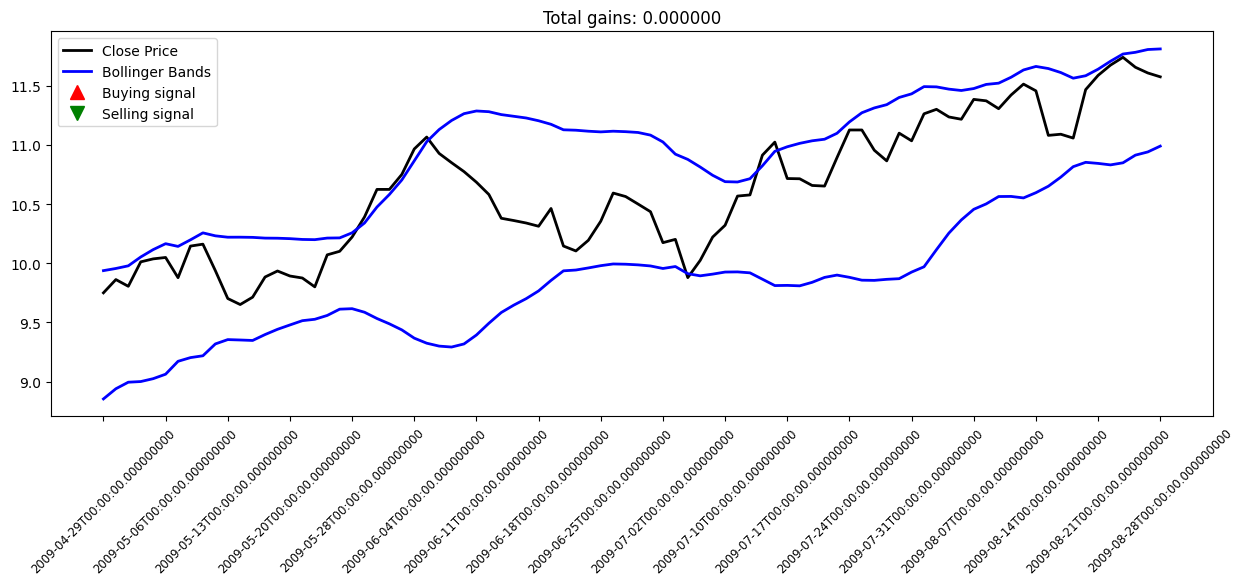

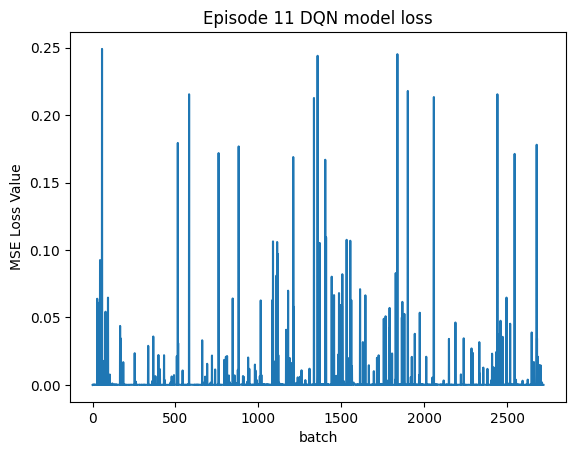

Running episode 12/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.89
Sell: $9.88 | Profit: -$0.02
Buy: $10.72
Sell: $10.71 | Profit: -$0.00
--------------------------------
Episode 12
Total Profit: -$0.02
Total Winners: $0.00
Total Losers: -$0.02
Max Loss: 0.25313884019851685
Total Loss: 3.741548804179773
--------------------------------


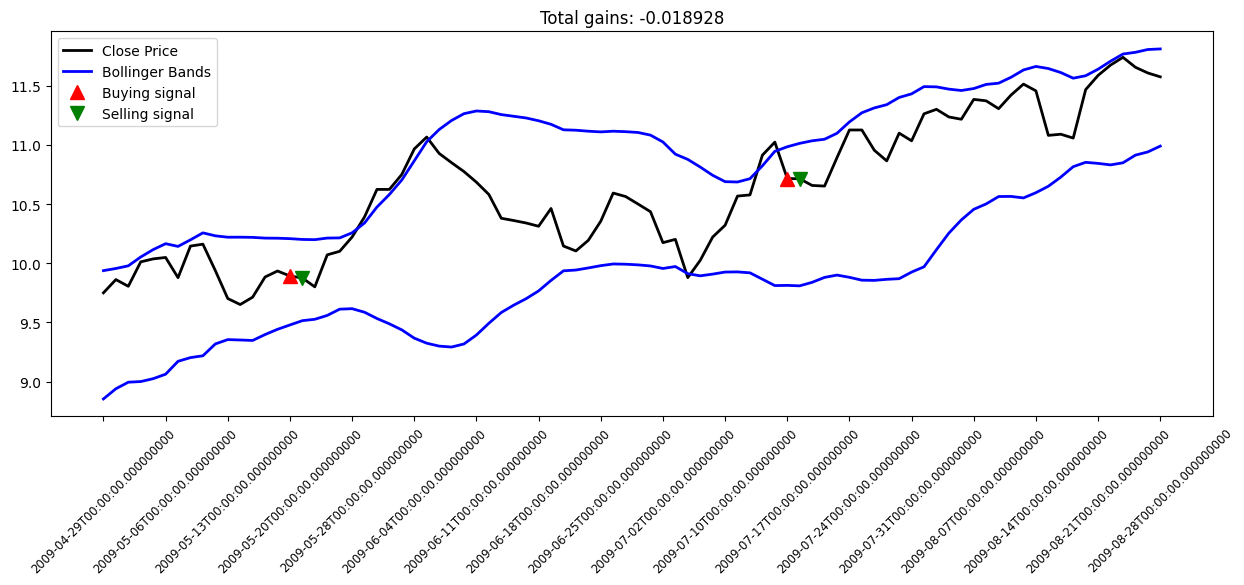

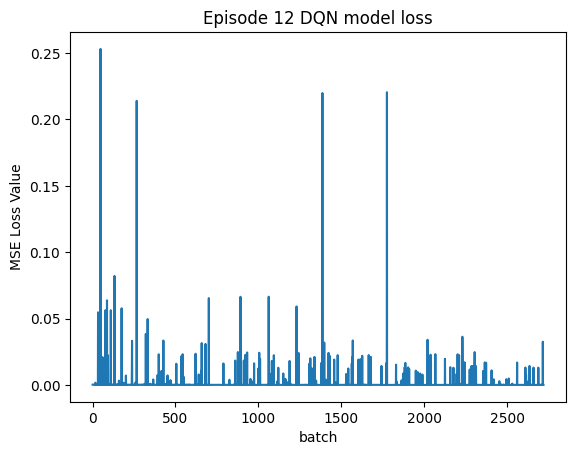

Running episode 13/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $9.71
Buy: $9.88
Buy: $9.93
Buy: $9.89
Sell: $9.88 | Profit: $0.16
Sell: $9.80 | Profit: -$0.08
Sell: $10.07 | Profit: $0.14
Sell: $10.10 | Profit: $0.21
Buy: $11.13
Sell: $11.13 | Profit: $0.00
--------------------------------
Episode 13
Total Profit: $0.42
Total Winners: $0.51
Total Losers: -$0.08
Max Loss: 0.22033661603927612
Total Loss: 2.407730176826902
--------------------------------


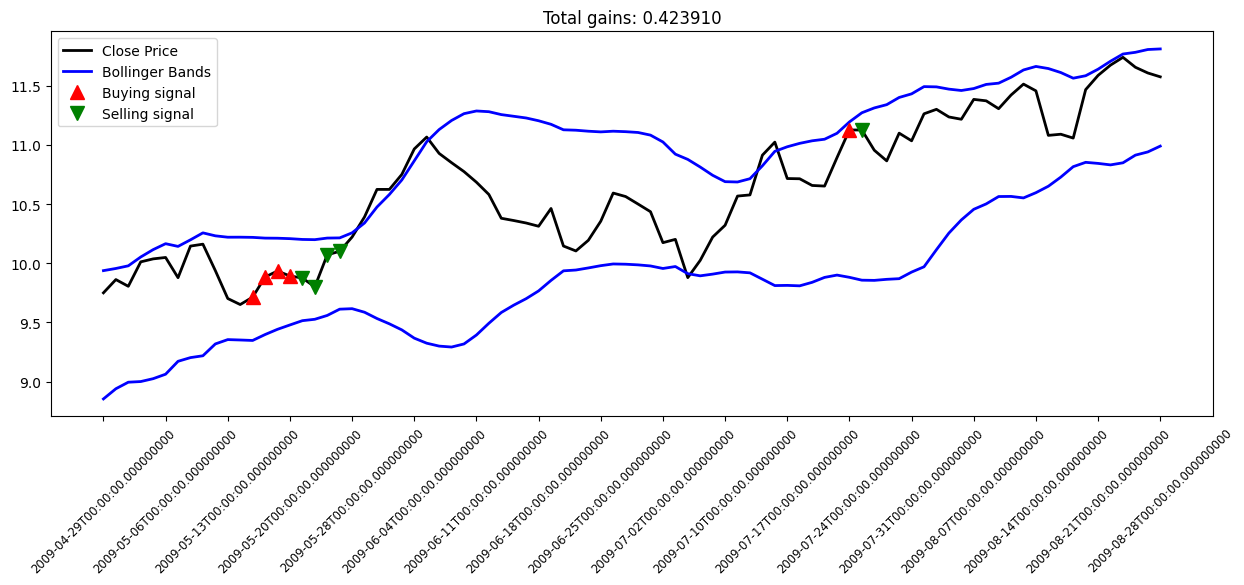

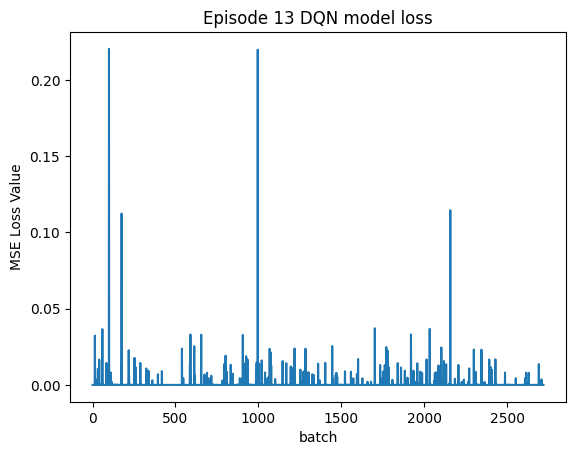

Running episode 14/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.16
Sell: $9.94 | Profit: -$0.22
--------------------------------
Episode 14
Total Profit: -$0.22
Total Winners: $0.00
Total Losers: -$0.22
Max Loss: 0.2210102081298828
Total Loss: 2.315958207913676
--------------------------------


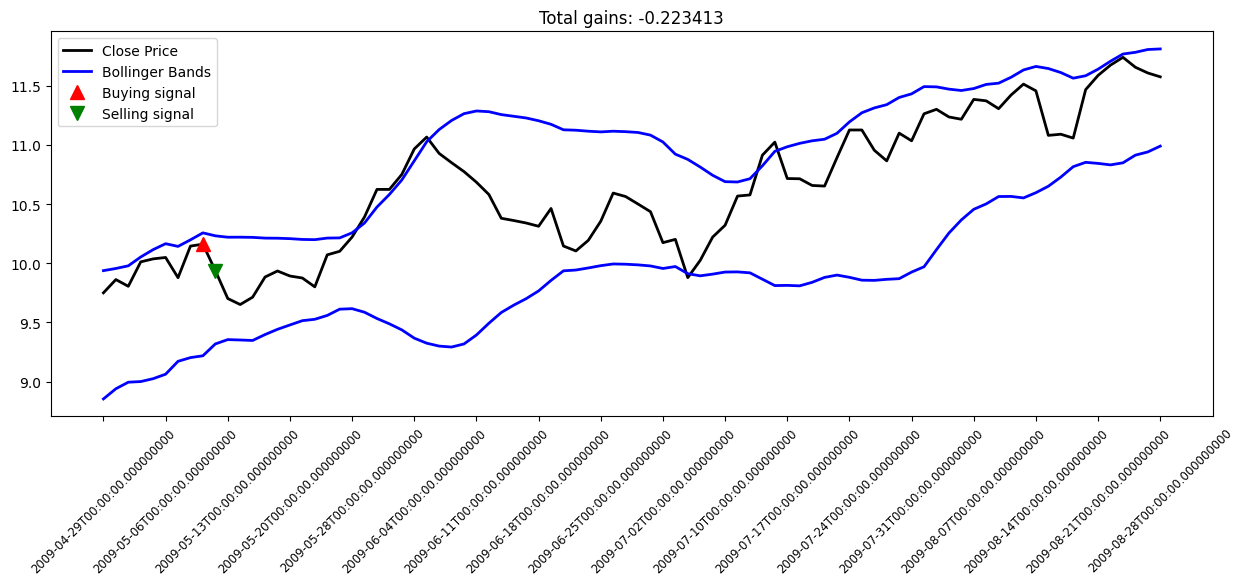

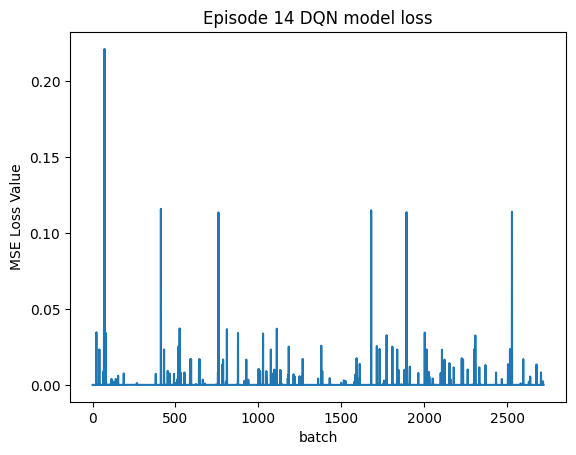

Running episode 15/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.85
Sell: $10.68 | Profit: -$0.16
Buy: $10.44
Sell: $10.17 | Profit: -$0.26
Buy: $10.58
Buy: $10.91
Sell: $11.02 | Profit: $0.45
Sell: $10.72 | Profit: -$0.20
Buy: $11.13
Sell: $10.96 | Profit: -$0.17
Buy: $10.87
Buy: $11.10
Sell: $11.03 | Profit: $0.17
Sell: $11.26 | Profit: $0.16
Buy: $11.24
Buy: $11.22
Sell: $11.38 | Profit: $0.15
Sell: $11.37 | Profit: $0.16
--------------------------------
Episode 15
Total Profit: $0.29
Total Winners: $1.08
Total Losers: -$0.79
Max Loss: 0.2234754115343094
Total Loss: 1.7226893079115484
--------------------------------


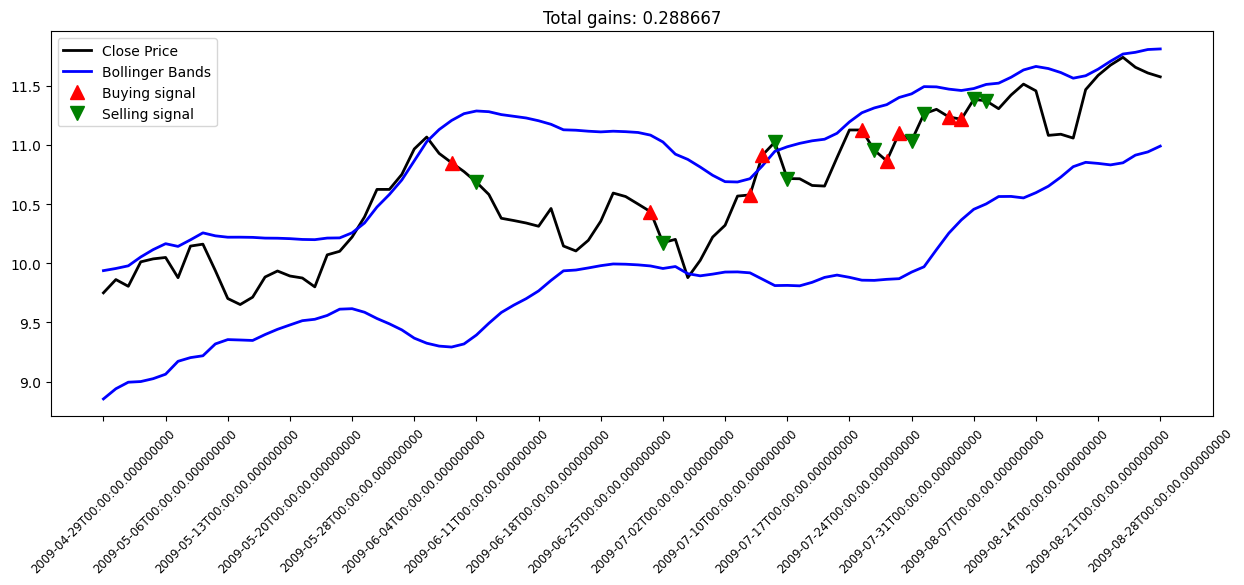

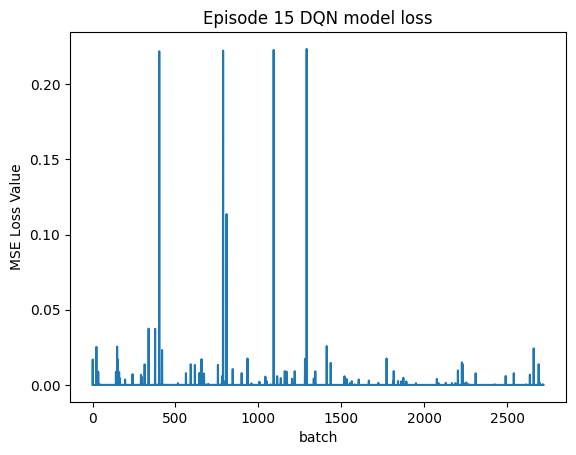

Running episode 16/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.07
Sell: $10.10 | Profit: $0.03
Buy: $10.58
Sell: $10.38 | Profit: -$0.20
Buy: $10.36
Sell: $10.59 | Profit: $0.24
Buy: $10.71
Sell: $10.66 | Profit: -$0.06
Buy: $11.03
Buy: $11.26
Sell: $11.30 | Profit: $0.27
Sell: $11.24 | Profit: -$0.03
Buy: $11.47
Sell: $11.59 | Profit: $0.12
--------------------------------
Episode 16
Total Profit: $0.37
Total Winners: $0.65
Total Losers: -$0.28
Max Loss: 0.22331690788269043
Total Loss: 1.6071210868911874
--------------------------------


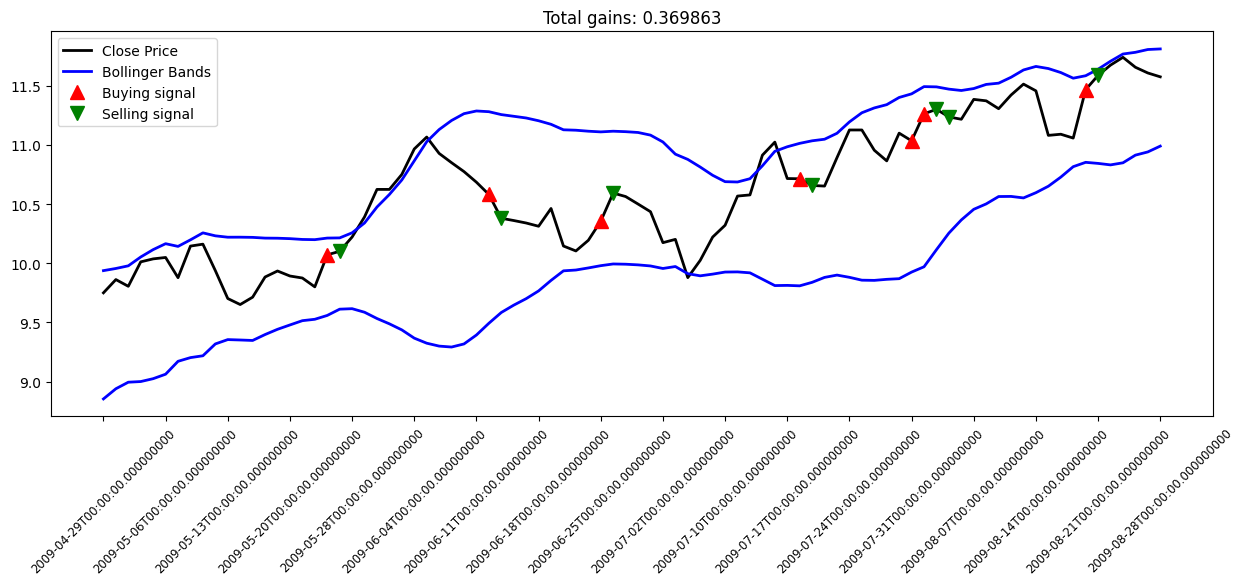

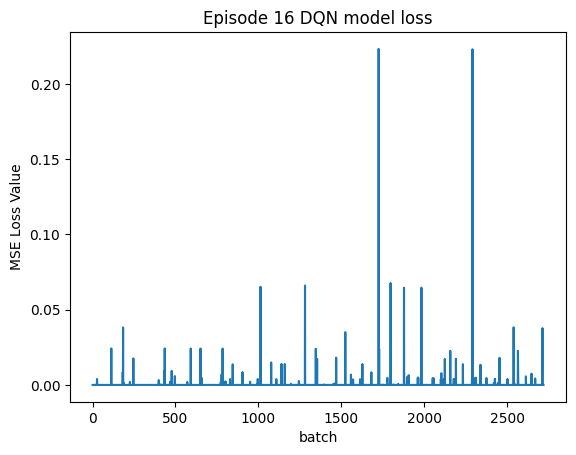

Running episode 17/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.59
Sell: $10.50 | Profit: -$0.09
Buy: $10.20
Sell: $9.88 | Profit: -$0.32
Buy: $11.26
Sell: $11.30 | Profit: $0.04
--------------------------------
Episode 17
Total Profit: -$0.38
Total Winners: $0.04
Total Losers: -$0.42
Max Loss: 0.06501592695713043
Total Loss: 1.0818212941500782
--------------------------------


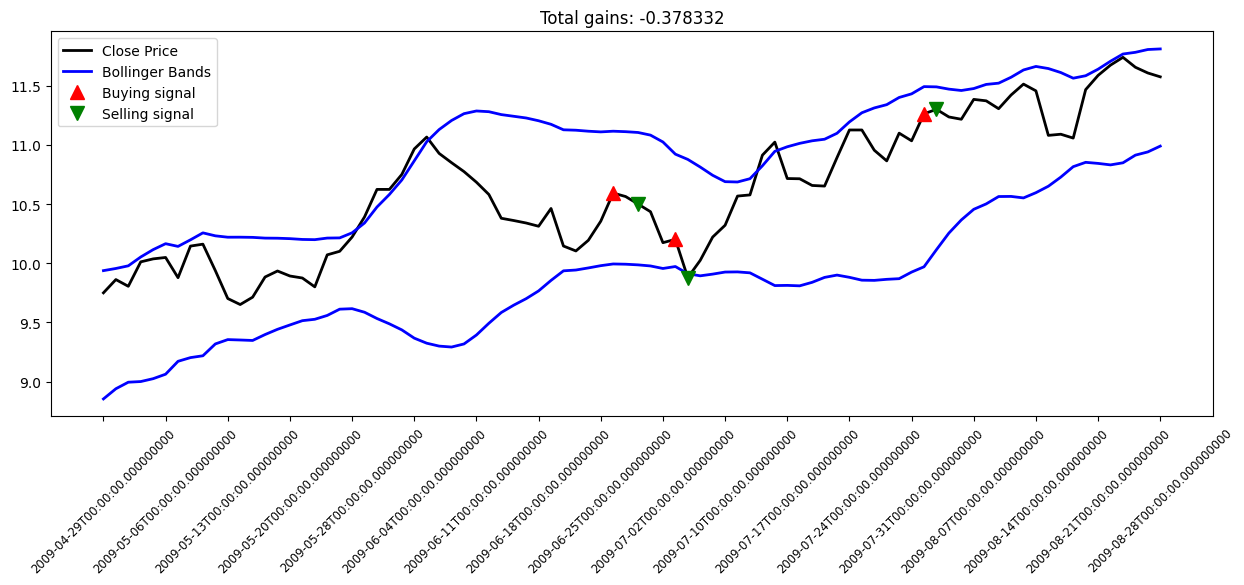

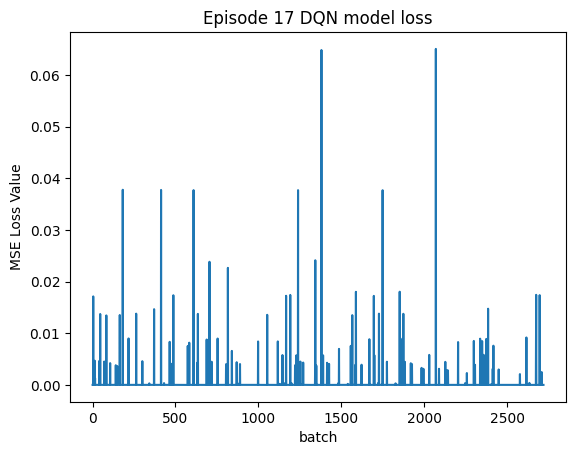

Running episode 18/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.04
Buy: $9.88
Sell: $10.15 | Profit: $0.11
Sell: $10.16 | Profit: $0.28
Buy: $10.10
Buy: $10.22
Sell: $10.62 | Profit: $0.52
Sell: $10.62 | Profit: $0.40
Buy: $10.97
Sell: $11.07 | Profit: $0.10
Buy: $10.68
Sell: $10.58 | Profit: -$0.10
Buy: $10.56
Sell: $10.44 | Profit: -$0.13
Buy: $11.02
Sell: $10.72 | Profit: -$0.31
Buy: $11.13
Sell: $11.13 | Profit: $0.00
Buy: $11.59
Sell: $11.67 | Profit: $0.09
--------------------------------
Episode 18
Total Profit: $0.96
Total Winners: $1.50
Total Losers: -$0.54
Max Loss: 0.08997756987810135
Total Loss: 0.7163883125362969
--------------------------------


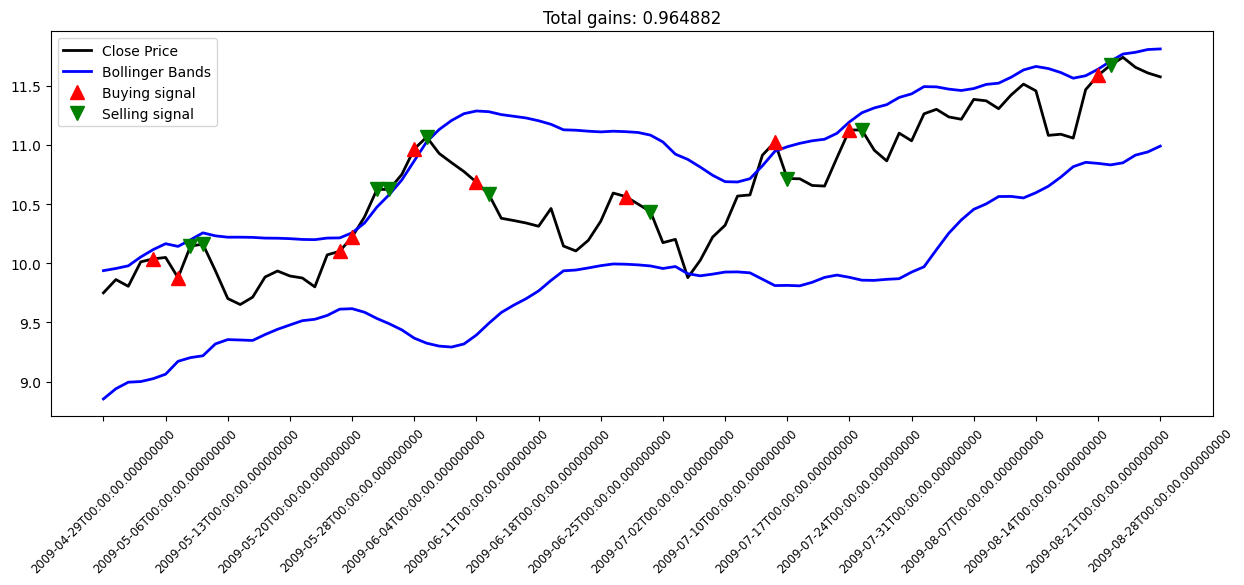

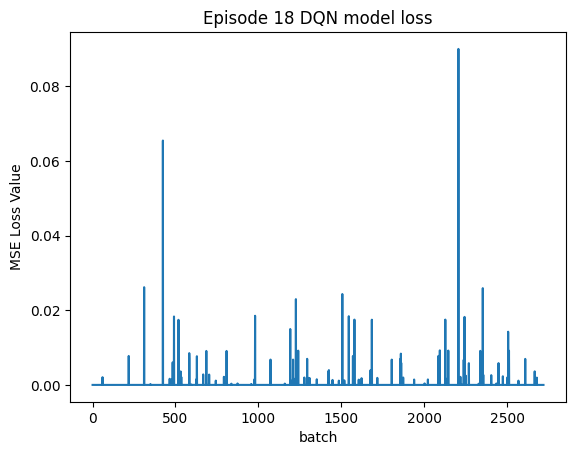

Running episode 19/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.04
Sell: $10.05 | Profit: $0.01
Buy: $10.68
Sell: $10.58 | Profit: -$0.10
Buy: $10.36
Buy: $10.59
Sell: $10.56 | Profit: $0.21
Sell: $10.50 | Profit: -$0.09
Buy: $11.13
Sell: $11.13 | Profit: $0.00
Buy: $11.26
Sell: $11.30 | Profit: $0.04
Buy: $11.31
Buy: $11.42
Sell: $11.51 | Profit: $0.21
Sell: $11.46 | Profit: $0.04
Buy: $11.61
--------------------------------
Episode 19
Total Profit: $0.30
Total Winners: $0.50
Total Losers: -$0.20
Max Loss: 0.08995690941810608
Total Loss: 1.1699233257724764
--------------------------------


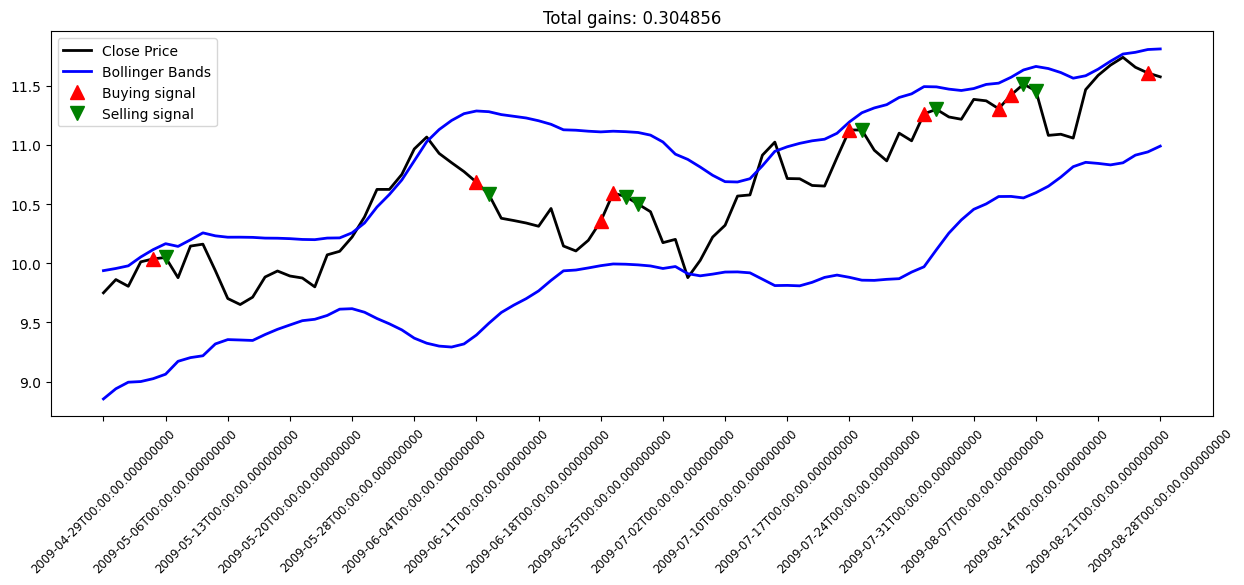

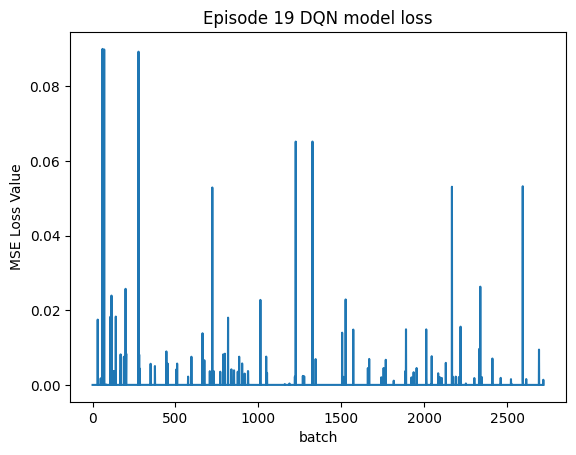

Running episode 20/20:   0%|          | 0/85 [00:00<?, ?it/s]

Buy: $10.36
Buy: $10.34
Buy: $10.31
Sell: $10.46 | Profit: $0.10
Sell: $10.15 | Profit: -$0.19
Sell: $10.10 | Profit: -$0.21
Buy: $11.03
Buy: $11.26
Buy: $11.30
Buy: $11.24
Buy: $11.22
Buy: $11.38
Sell: $11.37 | Profit: $0.34
Buy: $11.31
Buy: $11.42
Buy: $11.51
Sell: $11.46 | Profit: $0.19
Sell: $11.08 | Profit: -$0.22
Sell: $11.09 | Profit: -$0.15
Sell: $11.06 | Profit: -$0.16
Sell: $11.47 | Profit: $0.08
Sell: $11.59 | Profit: $0.28
Sell: $11.67 | Profit: $0.25
Sell: $11.74 | Profit: $0.23
--------------------------------
Episode 20
Total Profit: $0.55
Total Winners: $1.48
Total Losers: -$0.93
Max Loss: 0.08951050788164139
Total Loss: 1.6085745953316783
--------------------------------


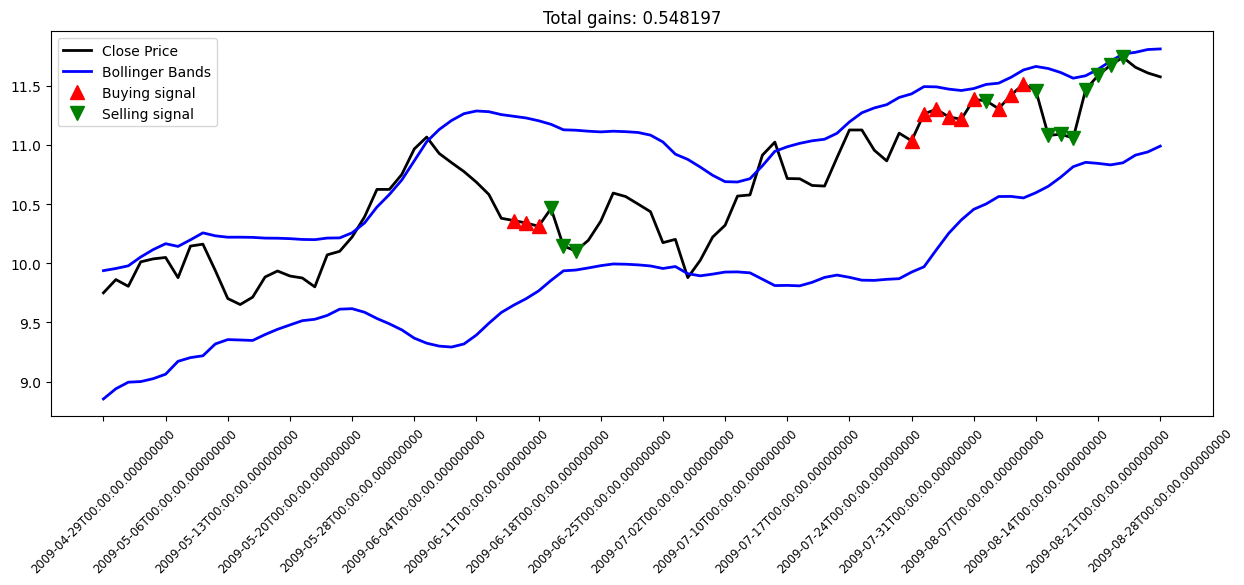

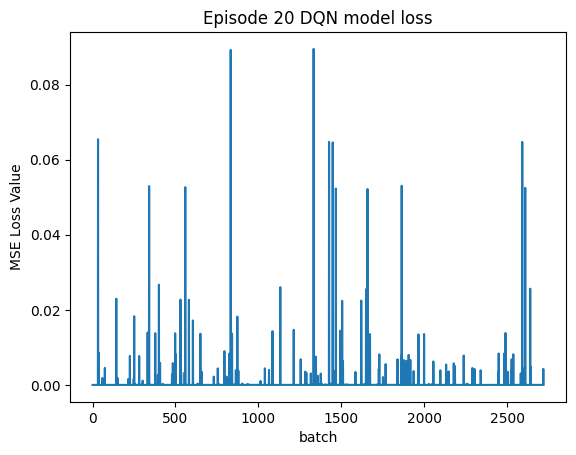

In [51]:
keras.config.disable_traceback_filtering() # disable built-in keras loading bars - they make the output difficult to read and monitor


l = len(X_train) - 1  # track number of examples in dataset (i.e. number of days to train on)

# batch size defines how often to run the exp_replay method
batch_size = 32

#An episode represents a complete pass over the data.
episode_count = 20

normalizer_close = normlist[idx_close] # get the close normalizer from normlist
normalizer_bb_upper = normlist[idx_bb_upper] # get the BB upper normalizer from normlist
normalizer_bb_lower = normlist[idx_bb_lower] # get the BB lower normalizer from normlist

X_train_true_price = normalizer_close.inverse_transform(X_train[:, idx_close].reshape(-1,1)).flatten() # inverse transform the Close column in X_train in order to get true close prices
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1,1)).flatten() # inverse transform the Upper BB column in X_train in order to get true Upper BB values
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1,1)).flatten() # inverse transform the Lower BB column in X_train in order to get true Lower BB values

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = get_state(X_train, 0, window_size + 1) # get the state for the first step
    # initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        # get the action
        action = agent.act(state)
        # get the next state
        next_state = get_state(X_train, t + 1, window_size + 1)

        # initialize reward for the current time step
        reward = 0

        if action == 1: # buy
            # inverse transform to get true buy price in dollars
            buy_price = normalizer_close.inverse_transform(np.array([[X_train[t, idx_close]]]))[0][0]
            # append the buy price to the inventory
            agent.inventory.append(buy_price)
            # append the time step to states_buy
            states_buy.append(t)
            # print the action and price of the action
            print(f'Buy: {format_price(buy_price)}')

        elif action == 2 and len(agent.inventory) > 0: # sell
            # get the bought price of the stock you are selling (i.e. the stock at the beginning of the inventory)
            bought_price = agent.inventory.pop(0)  
            # inverse transform to get true sell price in dollars
            sell_price = normalizer_close.inverse_transform(np.array([[X_train[t, idx_close]]]))[0][0]
            # define reward as max of profit (close price at time of sell - close price at time of buy) and 0
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            # add current profit to total profit
            total_profit += trade_profit
            if trade_profit >=0:
                # add current profit to total winners
                total_winners += trade_profit
            else:
                # add current profit to total losers
                total_losers += trade_profit
            # append the time step to states_sell
            states_sell.append(t)
            # print the action, price of the action, and profit of the action
            print(f'Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}')

        # flag for final training iteration
        done = True if t == l - 1 else False

        # append the details of the state action etc in the memory, to be used by the exp_replay function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        # when the size of the memory is greater than the batch size, run the exp_replay function on the batch to fit the model and get losses for the batch
        # then sum the losses for the batch and append them to the batch_losses list
        if len(agent.memory) > batch_size:
            mini_losses = agent.exp_replay(batch_size, losses=batch_losses)
            batch_losses += mini_losses

        # print total profit and plot behaviour of the current episode when the episode is finished
        if done:
            episode_losses = batch_losses[num_batches_trained:len(batch_losses)]
            max_loss = max(episode_losses) if episode_losses else 0
            total_loss = sum(episode_losses) if episode_losses else 0
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            print(f'Max Loss: {max_loss}')
            print(f'Total Loss: {total_loss}')
            print('--------------------------------')
            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:len(batch_losses)], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

    if e % 2 == 0:
        # save the model every 2 episodes (in case of crash or better training iteration in the middle of training process)
        agent.model.save(f'model_ep{e}.keras')

### Plot Training Loss

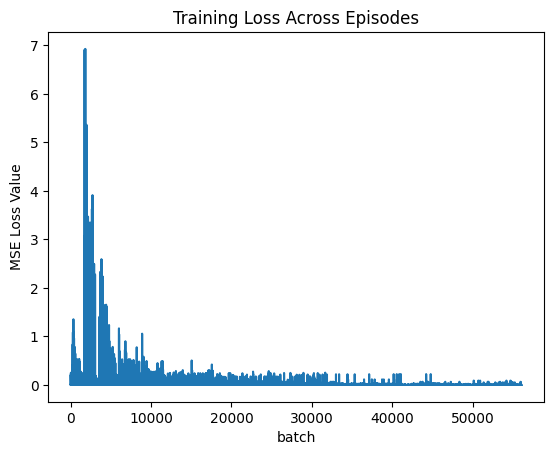

In [52]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, 'Training Loss Across Episodes')

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [53]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size + 1)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

#Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

state = get_state(X_test, 0, window_size + 1) # get the first state of the test dataset

X_test_true_price = normalizer_close.inverse_transform(X_test[:, idx_close].reshape(-1,1)).flatten() # true close price
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1,1)).flatten() # true BB upper
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1,1)).flatten() # true BB lower

### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

Buy: $11.50
Buy: $11.35
Buy: $11.28
Buy: $11.40
Buy: $11.49
Buy: $11.42
Buy: $11.56
Buy: $11.73
Buy: $11.76
Buy: $11.83
Buy: $11.89
Buy: $12.16
Buy: $12.25
Buy: $12.25
Buy: $12.38
Buy: $12.43
Buy: $12.41
Buy: $12.37
Buy: $12.27
Buy: $12.42
Buy: $12.42
Buy: $12.35
Buy: $12.13
Buy: $12.07
Buy: $12.17
Buy: $12.42
Buy: $12.89
Buy: $12.81
Buy: $12.86
Buy: $13.05
Buy: $13.10
Buy: $13.33
Buy: $13.20
Buy: $13.69
Buy: $13.75
Buy: $13.74
Buy: $13.73
Buy: $13.80
Buy: $13.79
Buy: $13.80
Buy: $13.66
Buy: $13.46
Buy: $13.72
Buy: $13.35
Buy: $13.30
Buy: $13.38
Buy: $13.46
Buy: $13.67
Buy: $13.73
Buy: $14.01
Buy: $14.12
Buy: $14.12
Buy: $14.14
Buy: $14.25
Buy: $14.35
Buy: $14.38
Buy: $14.36
Buy: $14.27
Buy: $14.20
Buy: $14.50
Buy: $14.52
Buy: $14.59
Buy: $14.44
Buy: $14.52
Buy: $14.69
Buy: $14.63
Buy: $14.59
Buy: $14.57
Buy: $14.60
Buy: $14.62
Buy: $14.67
Buy: $14.73
Buy: $14.71
Buy: $14.84
Buy: $14.77
Buy: $14.89
Buy: $14.79
Buy: $14.85
Buy: $14.91
Buy: $14.97
Buy: $15.23
Buy: $15.40
Buy: $15.51
Buy:

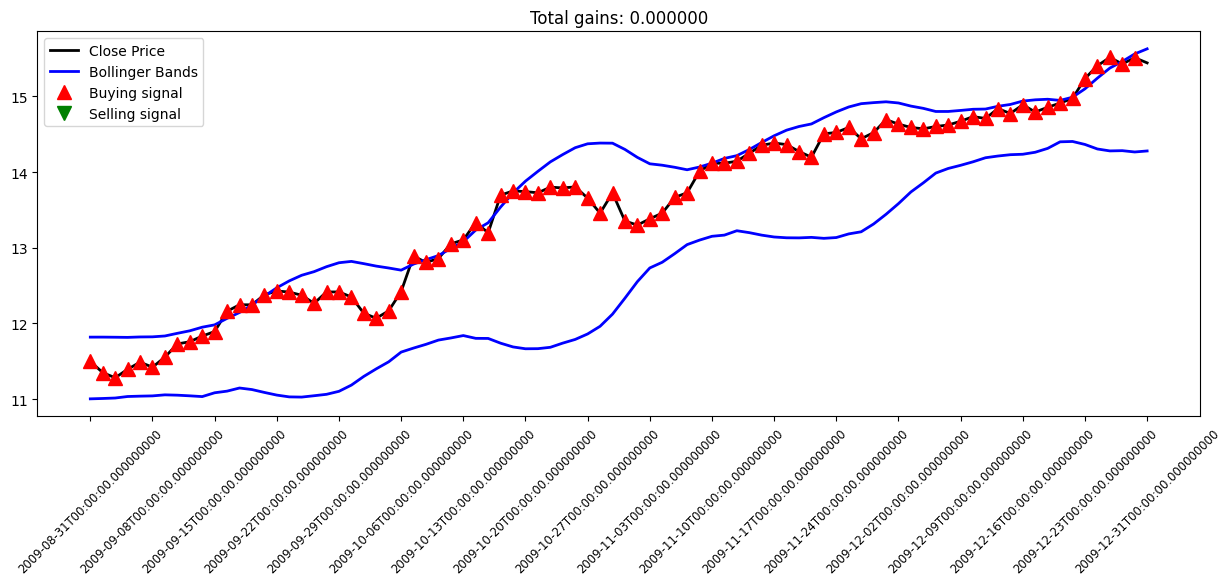

: 

In [ ]:
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size + 1)
    reward = 0

    if action == 1: # buy
        # inverse transform to get true buy price in dollars
        buy_price = normalizer_close.inverse_transform(np.array([[X_test[t, idx_close]]]))[0][0]
        # append buy prive to inventory
        agent.inventory.append(buy_price)
        # append time step to states_buy_test
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0: # sell
        # get bought price from beginning of inventory
        bought_price = agent.inventory.pop(0)
        # inverse transform to get true sell price in dollars
        sell_price = normalizer_close.inverse_transform(np.array([[X_test[t, idx_close]]]))[0][0]
        # reward is max of profit (close price at time of sell - close price at time of buy)
        reward = max(sell_price - bought_price, 0)
        # update total_test_profit
        total_profit += sell_price - bought_price
        # append time step to states_sell_test
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')


    if t == l_test - 1:
        done = True
    # append to memory so we can re-train on 'live' (test) data later    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')

plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)